## 필요한 Library

In [1]:
import os
import pandas as pd
import numpy as np
import math

In [2]:
#휴일 구하기
import datetime

def get_holidays(y, m, d):
    holidays=list([[1, 1],[2, 11],[2, 12],[2, 13],[3, 1],[5, 5],[5, 19],[6, 6],[8, 15],[9, 20],[9, 21],[9, 22],[10, 3],[10, 9],[12, 25]])
    
    if [m, d] in holidays:  # 공휴일 날짜 안에 속하면 True
        return 1
    date = datetime.date(y, m, d)
    return int(date.isoweekday() > 5) #토, 일요일이면 True

## 데이터 읽어오기
1. 맞춰야 할 변수 설명
- file_dir : raw data(6개)가 들어있는 폴더 위치. 해당 폴더에는 raw data만 들어있어야 함.

In [3]:
filename = list()
file_dir = "../Data/raw_data"  # 데이터 들어있는 폴더 위치
for f in os.listdir(file_dir):
    filename.append(f)

#파일 읽어오기
df1 = pd.read_csv(os.path.join(file_dir, filename[0])) #고객데모정보
df2 = pd.read_csv(os.path.join(file_dir, filename[1])) #유통사 상품 구매 내역
df3 = pd.read_csv(os.path.join(file_dir, filename[2])) #제휴사 서비스 이용 내역
df4 = pd.read_csv(os.path.join(file_dir, filename[3])) #유통사 상품 카테고리 마스터
df5 = pd.read_csv(os.path.join(file_dir, filename[4])) #유통사/제휴사 점포 마스터
df6 = pd.read_csv(os.path.join(file_dir, filename[5])) #엘페이 결제 내역

#컬럼명 변경
df1.rename(columns={'cust':'고객번호', 'ma_fem_dv':'성별', 'ages':'연령대', 'zon_hlv':'거주지'}, inplace=True)
df2.rename(columns={'cust':'고객번호', 'rct_no':'영수증', 'chnl_dv':'채널', 'cop_c':'유통사', 'pd_c':'상품코드', 'br_c':'점포코드', 'de_dt':'이용일자', 'de_hr':'이용시간', 'buy_am':'이용금액', 'buy_ct':'구매수량'}, inplace=True)
df3.rename(columns={'cust':'고객번호', 'rct_no':'영수증', 'cop_c':'제휴사', 'br_c':'점포코드', 'de_dt':'이용일자', 'vst_dt':'방문일자', 'de_hr':'이용시간', 'buy_am':'이용금액', 'chnl_dv':'채널'}, inplace=True)
df4.rename(columns={'pd_c':'상품코드', 'pd_nm':'소분류', 'clac_hlv_nm':'대분류', 'clac_mcls_nm':'중분류'}, inplace=True)
df5.rename(columns={'br_c':'점포코드', 'cop_c':'제휴사', 'zon_hlv':'점포_대분류', 'zon_mcls':'점포_중분류', 'chnl_dv':'채널'}, inplace=True)
df6.rename(columns={'cust':'고객번호', 'cop_c':'제휴사', 'rct_no':'영수증', 'de_dt':'이용일자', 'de_hr':'이용시간', 'buy_am':'이용금액', 'chnl_dv':'채널'}, inplace=True)

C:\Users\Seohyeon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## df_제휴사

In [4]:
# 1. df1, df3를 "고객번호" 기준으로 합
df_제휴사 = pd.merge(df3, df1, how='inner', on='고객번호')

if(len(df_제휴사) == len(df3)):
    print("df1과 df3이 성공적으로 merge 되었습니다.\n")
else:
    print("!! df1과 df3 merge과정 확인 필요 !!\n")
print(df_제휴사.isnull().sum()) #'점포코드'에만 null값 55개 존재

df1과 df3이 성공적으로 merge 되었습니다.

고객번호     0
영수증      0
제휴사      0
점포코드    55
채널       0
이용일자     0
방문일자     0
이용시간     0
이용금액     0
성별       0
연령대      0
거주지      0
dtype: int64


In [5]:
# 2. df_제휴사 와 df5 를 "점포코드" 기준으로 합 (이 때, df5의 제휴사는 고려하지 않았음)
test = pd.merge(df_제휴사.drop('제휴사', axis=1), df5, how='left', on='점포코드')
df_제휴사_test = pd.merge(df_제휴사, df5, how='left', on='점포코드')
if(len(test) == len(df_제휴사)):
    print("df5가 성공적으로 merge 되었습니다.\n")
    df_제휴사 = test.copy()
    del test
    print(df_제휴사.isnull().sum()) #'점포코드'null인 곳에만 null값 55개 존재
else:
    print("!! df_제휴사 + df5 merge과정 확인 필요 !!\n")

df5가 성공적으로 merge 되었습니다.

고객번호       0
영수증        0
점포코드      55
채널         0
이용일자       0
방문일자       0
이용시간       0
이용금액       0
성별         0
연령대        0
거주지        0
제휴사       55
점포_대분류    55
점포_중분류    55
dtype: int64


### Q1. 채널, 점포코드, null값이 관련있는가

In [6]:
sum(df_제휴사_test['채널']==2)

34779

In [7]:
sum(df_제휴사_test['점포코드'].isna())

55

In [8]:
sum(df_제휴사_test[df_제휴사_test['점포코드'].isna()]['채널']==2)

55

- 점포코드가 Null인 곳은 모두 ONLINE
- 온라인 판매를 하면서 점포가 있을수도 있는거지

### Q2. df3의 '제휴사'와 df5의 '제휴사'가 다른가

In [9]:
set(df3['제휴사'])

{'B01', 'C01', 'C02', 'D01', 'D02', 'E01'}

In [10]:
set(df5['제휴사'])

{'A01', 'A02', 'A03', 'A04', 'A05', 'B01', 'C01', 'C02', 'D01', 'D02', 'E01'}

In [11]:
sum(df_제휴사_test['제휴사_x'] != df_제휴사_test['제휴사_y']) 

55

In [12]:
set(df_제휴사_test[df_제휴사_test['제휴사_x'] != df_제휴사_test['제휴사_y']]['점포코드'])

{nan}

- df3의 '제휴사' : {'B01', 'C01', 'C02', 'D01', 'D02', 'E01'}
- df5의 '제휴사' : {'A01', 'A02', 'A03', 'A04', 'A05', 'B01', 'C01', 'C02', 'D01', 'D02', 'E01'}
- df3의 '제휴사'와 df5의 '제휴사'가 다른 경우는 df3의 점포코드가 NaN인 경우에만 존재한다.

In [13]:
df_제휴사_test[df_제휴사_test['제휴사_x'] != df_제휴사_test['제휴사_y']].head()

,고객번호,영수증,제휴사_x,점포코드,채널,이용일자,방문일자,이용시간,이용금액,성별,연령대,거주지,제휴사_y,점포_대분류,점포_중분류
8071,M715243116,21061019E011913828,E01,NaN,2,20210610,20210610,19,10000,남성,50대,Z10,NaN,NaN,NaN
21775,M528261257,21101717E013225469,E01,NaN,2,20211017,20211017,17,2035,여성,50대,Z11,NaN,NaN,NaN
29618,M630101164,21042615E011416951,E01,NaN,2,20210426,20210426,15,100000,남성,40대,Z05,NaN,NaN,NaN
41877,M313325679,21020312E011619104,E01,NaN,2,20210203,20210203,12,127520,남성,40대,Z10,NaN,NaN,NaN
47079,M793953321,21021921E015310194,E01,NaN,2,20210219,20210219,21,121740,여성,40대,Z12,NaN,NaN,NaN


In [14]:
set(df_제휴사_test[df_제휴사_test['제휴사_x'] != df_제휴사_test['제휴사_y']]['제휴사_x'])

{'E01'}

In [15]:
sum(df_제휴사_test['제휴사_x']=="E01")

6254

- df3의 '제휴사'가 E01(렌탈)인 경우는 6254개
- 그 중 55개의 경우 점포코드 Nan

### Q2-1. 그렇다면 df5는 어떤 데이터인가

In [16]:
set(df5['점포_대분류'])  #지역대분류코드

{'Z01',
 'Z02',
 'Z03',
 'Z04',
 'Z05',
 'Z06',
 'Z07',
 'Z08',
 'Z09',
 'Z10',
 'Z11',
 'Z12',
 'Z13',
 'Z14',
 'Z15',
 'Z16',
 'Z17'}

In [17]:
len(set(df5['점포_중분류']))

257

In [18]:
total = 0
for pattern in list(sorted(set(df5['점포_대분류']))):
    length = len(set(df5[df5['점포_중분류'].str.startswith(pattern)]['점포_중분류']))
    print(pattern, ": ", length)
    total += length
print("--------Total  :", total, "--------")

Z01 :  18
Z02 :  1
Z03 :  5
Z04 :  11
Z05 :  22
Z06 :  15
Z07 :  2
Z08 :  18
Z09 :  15
Z10 :  46
Z11 :  23
Z12 :  22
Z13 :  5
Z14 :  8
Z15 :  5
Z16 :  16
Z17 :  25
--------Total  : 257 --------


<AxesSubplot:xlabel='거주지', ylabel='Count'>

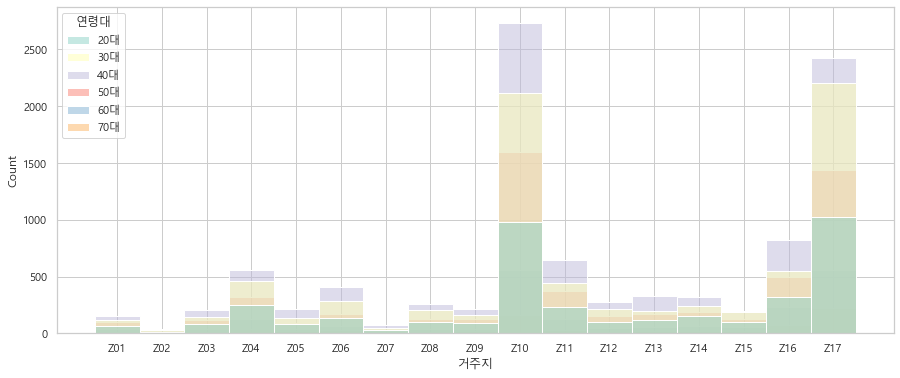

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['font.family'].insert(0, 'Malgun Gothic')
sns.set(font="Malgun Gothic", rc = {"axes.unicode_minus":False}, style='whitegrid')
plt.rcParams["figure.figsize"] = (15, 6)

custom_palette = sns.color_palette("Set3", 6)
sns.histplot(data=df1.sort_values(['거주지', '연령대']), x='거주지', hue='연령대', palette = custom_palette)

<AxesSubplot:xlabel='거주지', ylabel='Count'>

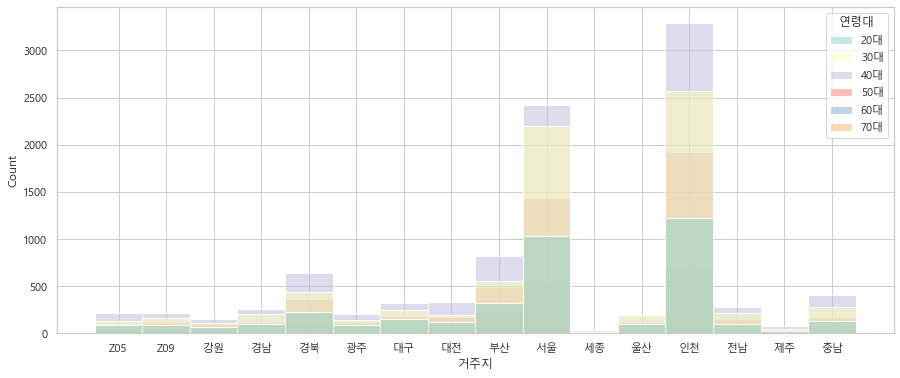

In [20]:
# 내 맘대로 추리해서 그려봄
df1_1 = df1.replace({'Z17':'서울', 'Z16':'부산', 'Z14':'대구', 'Z04':'인천', 'Z03':'광주',
                     'Z13':'대전', 'Z15':'울산', 'Z02':'세종', 'Z10':'인천', 'Z01':'강원',
                     'Z11':'경북', 'Z08':'경남', 'Z07':'제주', 'Z12':'전남', 'Z06':'충남'})
sns.histplot(data=df1_1.sort_values(['거주지', '연령대']), x='거주지', hue='연령대', palette = custom_palette)

- '점포_대분류' : 전국 행정구역 개수 17개 (서울, 부산, 대구, 인천, 광주, 대전, 울산, 세종, 경기, 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주)
- '점포_중분류' :
   - 서울(25): Z17
   - 부산(16): Z16
   - 대구(08): Z14
   - 인천(10): ?Z04
   - 광주(05): ?Z03
   - 대전(05): ?Z13
   - 울산(05): ?Z15
   - 세종(01): ?Z02
   
   - 경기(31): ?Z10
       - 경기도는 시군구 총 31개, 행정시/자치구가 아닌 구가 17개로 총 48개,,일수도
   - 강원(18): ?Z01
   - 충북(11):
   - 충남(15): ?Z06
   - 전북(14):
   - 전남(22): ?Z12
   - 경북(23): ?Z11
   - 경남(18): ?Z08
   
   - 제주(2?): ?Z07

### 생각을 정리하자면,
- df3 : 제휴사 서비스 이용내역
- df5 : 유통사/제휴사 점포 마스터

<br><br>
df5는 점포에 대한 정보이니까, df3과 df5를 합칠 때 제휴사는 고려할 필요가 없다는 결론..맞을까

In [21]:
# 3. df_제휴사 + LPAY 이용 여부
# 구분코드 = 고객번호 + 이용일자 + 이용시간 + 이용금액 + 채널 + 제휴사
df_제휴사['구분코드'] = df_제휴사['고객번호'] + df_제휴사['이용일자'].astype('str') + df_제휴사['이용시간'].astype('str') + df_제휴사['이용금액'].astype('str') + df_제휴사['채널'].astype('str') + df_제휴사['제휴사'].astype('str') 
df6['구분코드'] = df6['고객번호'] + df6['이용일자'].astype('str') + df6['이용시간'].astype('str') + df6['이용금액'].astype('str') + df6['채널'].astype('str') + df6['제휴사'].astype('str')

In [22]:
# 구분코드가 완전히 동일한 경우한 merge한다
# merge된 경우만 확인하기 위해 inner join
df3_6 = pd.merge(df_제휴사, df6.drop(['고객번호', '이용일자', '이용시간', '이용금액', '채널'], axis=1), how='inner', on='구분코드')
df3_6.head()

,고객번호,영수증_x,점포코드,채널,이용일자,방문일자,이용시간,이용금액,성별,연령대,거주지,제휴사_x,점포_대분류,점포_중분류,구분코드,영수증_y,제휴사_y
0,M819061016,21061414C012814154,C010030,2,20210614,20210614,14,10000,남성,70대,Z17,C01,Z10,Z10018,M8190610162021061414100002C01,210614140170019,C01
1,M819061016,21030807C014918101,C010030,2,20210308,20210308,7,10000,남성,70대,Z17,C01,Z10,Z10018,M819061016202103087100002C01,210308070107534,C01
2,M819061016,21091213C013717403,C010030,2,20210912,20210913,13,14000,남성,70대,Z17,C01,Z10,Z10018,M8190610162021091213140002C01,210912130134399,C01
3,M819061016,21040610C010718712,C010030,2,20210406,20210406,10,10000,남성,70대,Z17,C01,Z10,Z10018,M8190610162021040610100002C01,210406100128607,C01
4,M819061016,21041212C011112960,C010030,2,20210412,20210412,12,10000,남성,70대,Z17,C01,Z10,Z10018,M8190610162021041212100002C01,210412120151125,C01


In [23]:
print('df_제휴사 : ', len(df_제휴사))
print('merged    : ', len(df3_6))

df_제휴사 :  248304
merged    :  21472


In [24]:
df3_6.columns

Index(['고객번호', '영수증_x', '점포코드', '채널', '이용일자', '방문일자', '이용시간', '이용금액', '성별',
       '연령대', '거주지', '제휴사_x', '점포_대분류', '점포_중분류', '구분코드', '영수증_y', '제휴사_y'],
      dtype='object')

In [25]:
# 제휴사_x != 제휴사_y 인 경우는 merge가 잘못된 경우로 판단 -> 해당 사항 없음
df3_6[df3_6['제휴사_x']!=df3_6['제휴사_y']]

,고객번호,영수증_x,점포코드,채널,이용일자,방문일자,이용시간,이용금액,성별,연령대,거주지,제휴사_x,점포_대분류,점포_중분류,구분코드,영수증_y,제휴사_y


In [26]:
set(df3_6['제휴사_x'])

{'B01', 'C01', 'C02', 'D01', 'D02'}

In [27]:
set(df3_6['제휴사_y'])

{'B01', 'C01', 'C02', 'D01', 'D02'}

In [28]:
df3_6[(df3_6['제휴사_x']=='C02') & (df3_6['제휴사_y']=='C01')]

,고객번호,영수증_x,점포코드,채널,이용일자,방문일자,이용시간,이용금액,성별,연령대,거주지,제휴사_x,점포_대분류,점포_중분류,구분코드,영수증_y,제휴사_y


제휴사_x, 제휴사_y가 같은 계열 ({C01, C02}, {D01, D02}) 경우 없음

In [29]:
# LPOINT 이용한 경우의 영수증 번호만 저장
lpoint_yes = list(df3_6['영수증_x'].drop_duplicates())
lpoint_yes[:5]

['21061414C012814154',
 '21030807C014918101',
 '21091213C013717403',
 '21040610C010718712',
 '21041212C011112960']

In [30]:
len(lpoint_yes)

21114

In [31]:
# LPOINT 사용 여부 칼럼 생성
df_제휴사['LPoint'] = [0] * len(df_제휴사)
idx = df_제휴사.loc[df_제휴사['영수증'].isin(lpoint_yes)].index
df_제휴사.loc[idx, 'LPoint'] = 1

In [32]:
sum(df_제휴사['LPoint']) == len(lpoint_yes)

True

In [33]:
# LPoint 사용 안한 경우 남겨두기
lpointonly = list(set(df6['영수증']) - set(list(df3_6['영수증_y'].drop_duplicates())))
lpointonly[:6]

[210808170610688,
 211223200137218,
 211223200137219,
 210809200312323,
 210117140152324,
 211128210685960]

In [34]:
LP_wo3 = df6.loc[df6['영수증'].isin(lpointonly)]
len(LP_wo3) == len(lpointonly)

True

In [35]:
# 4. 휴일 column 추가 ('방문일자'가 토, 일, 공휴일이면 1, 아니면 0)
df_제휴사['휴일'] = df_제휴사['방문일자'].apply(lambda x: get_holidays(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [36]:
df_제휴사

,고객번호,영수증,점포코드,채널,이용일자,방문일자,이용시간,이용금액,성별,연령대,거주지,제휴사,점포_대분류,점포_중분류,구분코드,LPoint,휴일
0,M839993508,21102612B015763935,B010012,1,20211026,20211026,12,60000,남성,70대,Z17,B01,Z17,Z17024,M8399935082021102612600001B01,0,0
1,M839993508,21110610B014219744,B010012,1,20211106,20211106,10,17100,남성,70대,Z17,B01,Z17,Z17024,M8399935082021110610171001B01,0,1
2,M839993508,21021112B013419710,B010012,1,20210211,20210211,12,136500,남성,70대,Z17,B01,Z17,Z17024,M83999350820210211121365001B01,0,1
3,M839993508,21092010B012637545,B010012,1,20210920,20210920,10,34200,남성,70대,Z17,B01,Z17,Z17024,M8399935082021092010342001B01,0,1
4,M839993508,21101009D015920171,D010614,1,20211010,20211010,9,2500,남성,70대,Z17,D01,Z17,Z17018,M83999350820211010925001D01,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248299,M321652667,21092413D013710723,D010143,1,20210924,20210924,13,16400,여성,20대,Z13,D01,Z13,Z13001,M3216526672021092413164001D01,0,0
248300,M321652667,21101812D023790496,D020245,1,20211018,20211018,12,9100,여성,20대,Z13,D02,Z17,Z17020,M321652667202110181291001D02,0,0
248301,M736929241,21091422C014625802,C010011,2,20210914,20210915,22,26000,남성,20대,Z17,C01,Z17,Z17018,M7369292412021091422260002C01,0,0
248302,M040608978,21102916C024520111,C020002,1,20211029,20211029,16,27500,남성,20대,Z04,C02,Z17,Z17018,M0406089782021102916275001C02,0,0


In [37]:
sum(df_제휴사['휴일'])

94329

In [61]:
df_제휴사.drop('구분코드', axis=1, inplace = True)

## df_유통사

In [38]:
# 1. df1, df2를 "고객번호" 기준으로 merge
df_유통사 = pd.merge(df2, df1, how='inner', on='고객번호')

if(len(df_유통사) == len(df2)):
    print("df1과 df2이 성공적으로 merge 되었습니다.\n")
else:
    print("!! df1과 df2 merge과정 확인 필요 !!\n")
print(df_유통사.isnull().sum()) #'점포코드'에만 null값 55개 존재

df1과 df2이 성공적으로 merge 되었습니다.

고객번호         0
영수증          0
채널           0
유통사          0
점포코드    428501
상품코드         0
이용일자         0
이용시간         0
이용금액         0
구매수량         0
성별           0
연령대          0
거주지          0
dtype: int64


In [39]:
df_유통사

,고객번호,영수증,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,성별,연령대,거주지
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,여성,50대,Z17
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,여성,50대,Z17
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,여성,50대,Z17
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,여성,50대,Z17
4,M430112881,A01000005297,1,A01,A010039,PD1692,20210101,10,9900.0,1,여성,50대,Z17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381738,M498069014,E06052019590,2,A06,NaN,PD0507,20211227,16,100000.0,1,여성,40대,Z14
4381739,M498069014,E06052019590,2,A06,NaN,PD0507,20211227,16,100000.0,1,여성,40대,Z14
4381740,M498069014,E06052019590,2,A06,NaN,PD0507,20211227,16,100000.0,1,여성,40대,Z14
4381741,M498069014,E06052019590,2,A06,NaN,PD0507,20211227,16,100000.0,1,여성,40대,Z14


In [40]:
# 2. df_유통사, df4를 "상품코드" 기준으로 merge
test = pd.merge(df_유통사, df4, how='inner', on='상품코드')

if(len(test) == len(df_유통사)):
    print("df_유통사 와 df4가 성공적으로 merge 되었습니다.\n")
    print('len(df_유통사) = ', len(df_유통사), '\n')
    df_유통사 = test.copy()
    del test
    print(df_유통사.isnull().sum()) #'점포코드'에만 null값 428501개 존재
else:
    print("!! df_유통사과 df4 merge과정 확인 필요 !!\n")

df_유통사 와 df4가 성공적으로 merge 되었습니다.

len(df_유통사) =  4381743 

고객번호         0
영수증          0
채널           0
유통사          0
점포코드    428501
상품코드         0
이용일자         0
이용시간         0
이용금액         0
구매수량         0
성별           0
연령대          0
거주지          0
소분류          0
대분류          0
중분류          0
dtype: int64


### Q1. 채널, 점포코드 관계 확인

In [41]:
set(df_유통사[df_유통사['점포코드'].isna()]['채널'])

{2}

In [42]:
test = df_유통사[df_유통사['채널']==2]
display(test[test['점포코드'].notna()])

del test

,고객번호,영수증,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,성별,연령대,거주지,소분류,대분류,중분류


- 점포코드가 Null -> 온라인으로만 상품 제공 (역도 성립)

In [43]:
df_유통사.columns

Index(['고객번호', '영수증', '채널', '유통사', '점포코드', '상품코드', '이용일자', '이용시간', '이용금액',
       '구매수량', '성별', '연령대', '거주지', '소분류', '대분류', '중분류'],
      dtype='object')

In [44]:
df5

,점포코드,제휴사,점포_대분류,점포_중분류
0,A010001,A01,Z17,Z17024
1,A010002,A01,Z17,Z17018
2,A010003,A01,Z17,Z17011
3,A010004,A01,Z16,Z16007
4,A010005,A01,Z17,Z17005
...,...,...,...,...
8803,E010040,E01,Z17,Z17024
8804,E010041,E01,Z16,Z16005
8805,E010042,E01,Z17,Z17021
8806,E010043,E01,Z10,Z10035


In [45]:
# 3. df_유통사, df5를 "점포코드" 기준으로 merge
test = pd.merge(df_유통사, df5, how='left', on='점포코드') #점포코드에 null값있으므로 left join

if(len(test) == len(df_유통사)):
    print("df_유통사 와 df5가 성공적으로 merge 되었습니다.\n")
    print('len(df_유통사) = ', len(df_유통사), '\n')
    df_유통사 = test.copy()
    del test
    print(df_유통사.isnull().sum()) #'점포코드'에만 null값 428501개 존재
else:
    print("!! df_유통사과 df5 merge과정 확인 필요 !!\n")

df_유통사 와 df5가 성공적으로 merge 되었습니다.

len(df_유통사) =  4381743 

고객번호           0
영수증            0
채널             0
유통사            0
점포코드      428501
상품코드           0
이용일자           0
이용시간           0
이용금액           0
구매수량           0
성별             0
연령대            0
거주지            0
소분류            0
대분류            0
중분류            0
제휴사       428501
점포_대분류    428501
점포_중분류    428501
dtype: int64


In [46]:
df_유통사.columns

Index(['고객번호', '영수증', '채널', '유통사', '점포코드', '상품코드', '이용일자', '이용시간', '이용금액',
       '구매수량', '성별', '연령대', '거주지', '소분류', '대분류', '중분류', '제휴사', '점포_대분류',
       '점포_중분류'],
      dtype='object')

In [47]:
df6.columns

Index(['고객번호', '영수증', '제휴사', '채널', '이용일자', '이용시간', '이용금액', '구분코드'], dtype='object')

In [48]:
# 4. df_유통사 + LPAY 이용 여부
df_유통사['구분코드'] = df_유통사['고객번호'] + df_유통사['이용일자'].astype('str') + df_유통사['이용시간'].astype('str') + df_유통사['이용금액'].astype('int').astype('str') + df_유통사['채널'].astype('str') + df_유통사['제휴사'].astype('str')
df6['구분코드'] = df6['고객번호'] + df6['이용일자'].astype('str') + df6['이용시간'].astype('str') + df6['이용금액'].astype('str') + df6['채널'].astype('str') + df6['제휴사'].astype('str')

In [49]:
# 구분코드가 완전히 동일한 경우한 merge한다
# merge된 경우만 확인하기 위해 inner join
df2_6 = pd.merge(df_유통사, df6.drop(['고객번호', '이용일자', '이용시간', '이용금액', '채널'], axis=1), how='inner', on='구분코드')
df2_6.head()

,고객번호,영수증_x,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,...,거주지,소분류,대분류,중분류,제휴사_x,점포_대분류,점포_중분류,구분코드,영수증_y,제휴사_y
0,M511106441,A01041114399,1,A01,A010045,PD0290,20210207,14,63600.0,1,...,Z16,남성티셔츠,남성의류,남성의류상의,A01,Z16,Z16003,M5111064412021020714636001A01,210207140159045,A01
1,M048866855,A01365299487,1,A01,A010064,PD0290,20210926,19,93870.0,1,...,Z10,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10040,M0488668552021092619938701A01,210926190163746,A01
2,M048866855,A01365346120,1,A01,A010064,PD0290,20210926,19,105840.0,1,...,Z10,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10040,M04886685520210926191058401A01,210926190165101,A01
3,M355489415,A01041556273,1,A01,A010029,PD0290,20210207,16,69000.0,1,...,Z10,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10025,M3554894152021020716690001A01,210207160168326,A01
4,M088827294,A01405533230,1,A01,A010024,PD0290,20211024,14,138600.0,1,...,Z16,남성티셔츠,남성의류,남성의류상의,A01,Z11,Z11004,M08882729420211024141386001A01,211024140129471,A01


In [50]:
# 제휴사_x != 제휴사_y 인 경우는 merge가 잘못된 경우로 판단 -> 해당 사항 없음
df2_6[df2_6['제휴사_x']!=df2_6['제휴사_y']]

,고객번호,영수증_x,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,...,거주지,소분류,대분류,중분류,제휴사_x,점포_대분류,점포_중분류,구분코드,영수증_y,제휴사_y


In [51]:
# LPOINT 이용한 경우의 영수증 번호만 저장
lpoint_yes = list(df2_6['영수증_x'].drop_duplicates())

In [52]:
# LPOINT 사용 여부 칼럼 생성
df_유통사['LPoint'] = [0] * len(df_유통사)
idx = df_유통사.loc[df_유통사['영수증'].isin(lpoint_yes)].index
df_유통사.loc[idx, 'LPoint'] = 1

In [53]:
df_유통사

,고객번호,영수증,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,...,연령대,거주지,소분류,대분류,중분류,제휴사,점포_대분류,점포_중분류,구분코드,LPoint
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,...,50대,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110150001A01,0
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,50대,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110190001A01,0
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,50대,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110190001A01,0
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,50대,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110190001A01,0
4,M646853852,A01269523084,1,A01,A010025,PD0290,20210716,20,20000.0,1,...,40대,Z13,남성티셔츠,남성의류,남성의류상의,A01,Z13,Z13001,M6468538522021071620200001A01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381738,M057015266,A04011192485,1,A04,A043075,PD0514,20210215,17,5000.0,1,...,40대,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M057015266202102151750001A04,0
4381739,M057015266,A04037050987,1,A04,A043075,PD0514,20210512,20,10000.0,1,...,40대,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M0570152662021051220100001A04,0
4381740,M057015266,A04037050987,1,A04,A043075,PD0514,20210512,20,10000.0,1,...,40대,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M0570152662021051220100001A04,0
4381741,M057015266,A04037050987,1,A04,A043075,PD0514,20210512,20,10000.0,1,...,40대,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M0570152662021051220100001A04,0


In [54]:
# LPoint 사용 안한 경우 남겨두기
lpointonly = list(set(df6['영수증']) - set(list(df3_6['영수증_y'].drop_duplicates())))
lpointonly[:6]

[210808170610688,
 211223200137218,
 211223200137219,
 210809200312323,
 210117140152324,
 211128210685960]

In [55]:
LP_wo2 = df6.loc[df6['영수증'].isin(lpointonly)]
len(LP_wo2) == len(lpointonly)

True

In [56]:
# 4. 휴일 column 추가 ('이용일자'가 토, 일, 공휴일이면 1, 아니면 0)
df_유통사['휴일'] = df_유통사['이용일자'].apply(lambda x: get_holidays(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [57]:
df_유통사

,고객번호,영수증,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,...,거주지,소분류,대분류,중분류,제휴사,점포_대분류,점포_중분류,구분코드,LPoint,휴일
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,...,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110150001A01,0,1
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110190001A01,0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110190001A01,0,1
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,M4301128812021010110190001A01,0,1
4,M646853852,A01269523084,1,A01,A010025,PD0290,20210716,20,20000.0,1,...,Z13,남성티셔츠,남성의류,남성의류상의,A01,Z13,Z13001,M6468538522021071620200001A01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381738,M057015266,A04011192485,1,A04,A043075,PD0514,20210215,17,5000.0,1,...,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M057015266202102151750001A04,0,0
4381739,M057015266,A04037050987,1,A04,A043075,PD0514,20210512,20,10000.0,1,...,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M0570152662021051220100001A04,0,0
4381740,M057015266,A04037050987,1,A04,A043075,PD0514,20210512,20,10000.0,1,...,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M0570152662021051220100001A04,0,0
4381741,M057015266,A04037050987,1,A04,A043075,PD0514,20210512,20,10000.0,1,...,Z10,영화/문화/도서상품권,상품권,지류상품권,A04,Z10,Z10024,M0570152662021051220100001A04,0,0


In [58]:
df6

,고객번호,영수증,제휴사,채널,이용일자,이용시간,이용금액,구분코드
0,M629656521,210803210311226,A03,1,20210803,21,10900,M6296565212021080321109001A03
1,M216016456,210803130167542,L01,2,20210803,13,6860,M216016456202108031368602L01
2,M205142844,210803140275112,A02,1,20210803,14,9000,M205142844202108031490001A02
3,M737010483,210803040637594,A06,2,20210803,4,36740,M737010483202108034367402A06
4,M707775545,210803140675502,A06,2,20210803,14,138500,M70777554520210803141385002A06
...,...,...,...,...,...,...,...,...
353179,M470112503,210125110644545,A06,2,20210125,11,51800,M4701125032021012511518002A06
353180,M470112503,210104210652271,A06,2,20210104,21,6440,M470112503202101042164402A06
353181,M748878049,210119200278240,A02,1,20210119,20,17600,M7488780492021011920176001A02
353182,M748878049,210119180267206,A02,1,20210119,18,12400,M7488780492021011918124001A02
